In [1]:
from influxdb import InfluxDBClient
import pandas as pd
from matplotlib import pyplot as plt
import statsmodels.api as sm
import numpy as np
from datetime import datetime, timedelta
from dateutil.parser import parse

In [2]:
client = InfluxDBClient('localhost', 8086, 'root', 'root', 'VirtualBuilding')
q = 'SELECT * FROM "VirtualBuilding"."autogen"."meters_and_sensors" WHERE time<now()'
df_raw = pd.DataFrame(client.query(q).get_points())  # Returns all points

In [3]:
df_raw

,time,location,node,value
0,2017-01-01T01:00:00Z,VirtualBuilding,power_cooling,0.000000
1,2017-01-01T01:00:00Z,VirtualBuilding,power_electricity,0.610739
2,2017-01-01T01:00:00Z,VirtualBuilding,power_heating,0.000000
3,2017-01-01T01:00:00Z,VirtualBuilding,t_in,14.053807
4,2017-01-01T01:00:00Z,VirtualBuilding,t_out,0.925000
...,...,...,...,...
183955,2019-12-31T23:59:59Z,VirtualBuilding,power_heating,17.285040
183956,2019-12-31T23:59:59Z,VirtualBuilding,t_in,16.556033
183957,2019-12-31T23:59:59Z,VirtualBuilding,t_out,0.275000
183958,2019-12-31T23:59:59Z,VirtualBuilding,temp_diff,16.281033


In [4]:
df_piv = df_raw.pivot(index='time', columns='node', values=['value'])
df_piv.dropna(inplace=True)
df_piv

value                                             \
node                 power_cooling power_electricity power_heating       t_in   
time                                                                            
2017-01-01T01:00:00Z           0.0          0.610739      0.000000  14.053807   
2017-01-01T02:00:00Z           0.0          0.610739      0.000000  13.498118   
2017-01-01T03:00:00Z           0.0          0.610739      0.221951  13.159769   
2017-01-01T04:00:00Z           0.0          0.610739      1.160487  12.922441   
2017-01-01T05:00:00Z           0.0          0.610739      2.092721  12.756649   
...                            ...               ...           ...        ...   
2019-12-31T20:00:00Z           0.0         11.521435     24.817454  16.770866   
2019-12-31T21:00:00Z           0.0         11.521435     24.065884  16.874417   
2019-12-31T22:00:00Z           0.0         11.521435     23.390958  16.945011   
2019-12-31T23:00:00Z           0.0         11.521435     22.253470  16.994231   
2019-12-31T23:59:59Z           0.0          4.901261     17.285040  16.556033   

                                                    
node                  t_out  temp_diff total_power  
time                                                
2017-01-01T01:00:00Z  0.925  13.128807    0.000000  
2017-01-01T02:00:00Z  0.650  12.848118    0.000000  
2017-01-01T03:00:00Z  0.850  12.309769    0.221951  
2017-01-01T04:00:00Z  0.975  11.947441    1.160487  
2017-01-01T05:00:00Z  1.000  11.756649    2.092721  
...                     ...        ...         ...  
2019-12-31T20:00:00Z  0.875  15.895866   24.817454  
2019-12-31T21:00:00Z  0.575  16.299417   24.065884  
2019-12-31T22:00:00Z  0.275  16.670011   23.390958  
2019-12-31T23:00:00Z  0.200  16.794231   22.253470  
2019-12-31T23:59:59Z  0.275  16.281033   17.285040  

[26280 rows x 7 columns]

In [5]:
# importing csv
cols = [i for i in df_piv.columns if i !="time"]

for col in cols:
    # converting to float
    df_piv[col] = df_piv[col].astype(float)

In [6]:
df_piv = df_piv.droplevel(0,axis=1)
df_piv = df_piv.rename_axis(None)

In [7]:
df_piv

node,power_cooling,power_electricity,power_heating,t_in,t_out,temp_diff,total_power
2017-01-01T01:00:00Z,0.0,0.610739,0.000000,14.053807,0.925,13.128807,0.000000
2017-01-01T02:00:00Z,0.0,0.610739,0.000000,13.498118,0.650,12.848118,0.000000
2017-01-01T03:00:00Z,0.0,0.610739,0.221951,13.159769,0.850,12.309769,0.221951
2017-01-01T04:00:00Z,0.0,0.610739,1.160487,12.922441,0.975,11.947441,1.160487
2017-01-01T05:00:00Z,0.0,0.610739,2.092721,12.756649,1.000,11.756649,2.092721
...,...,...,...,...,...,...,...
2019-12-31T20:00:00Z,0.0,11.521435,24.817454,16.770866,0.875,15.895866,24.817454
2019-12-31T21:00:00Z,0.0,11.521435,24.065884,16.874417,0.575,16.299417,24.065884
2019-12-31T22:00:00Z,0.0,11.521435,23.390958,16.945011,0.275,16.670011,23.390958
2019-12-31T23:00:00Z,0.0,11.521435,22.253470,16.994231,0.200,16.794231,22.253470


In [8]:
time = []
for i in range(len(df_piv.index)):
    # reading  index
    t = df_piv.index[i]
    t_datetime = parse(t)
    timestamp=t_datetime.strftime("%Y/%m/%d  %H:%M:%S")
    # splitting day and hour
    #day, hour = t.split('  ')
    time.append(timestamp)
df_piv.index = pd.to_datetime(time)
df_piv

node,power_cooling,power_electricity,power_heating,t_in,t_out,temp_diff,total_power
2017-01-01 01:00:00,0.0,0.610739,0.000000,14.053807,0.925,13.128807,0.000000
2017-01-01 02:00:00,0.0,0.610739,0.000000,13.498118,0.650,12.848118,0.000000
2017-01-01 03:00:00,0.0,0.610739,0.221951,13.159769,0.850,12.309769,0.221951
2017-01-01 04:00:00,0.0,0.610739,1.160487,12.922441,0.975,11.947441,1.160487
2017-01-01 05:00:00,0.0,0.610739,2.092721,12.756649,1.000,11.756649,2.092721
...,...,...,...,...,...,...,...
2019-12-31 20:00:00,0.0,11.521435,24.817454,16.770866,0.875,15.895866,24.817454
2019-12-31 21:00:00,0.0,11.521435,24.065884,16.874417,0.575,16.299417,24.065884
2019-12-31 22:00:00,0.0,11.521435,23.390958,16.945011,0.275,16.670011,23.390958
2019-12-31 23:00:00,0.0,11.521435,22.253470,16.994231,0.200,16.794231,22.253470


In [9]:
##input: data to be plotted, title of the graph
def plotting(dat,tit):
    # model for regression
    model = sm.OLS(dat.total_power,sm.add_constant(dat.temp_diff))
    # fitting the model
    results = model.fit()
    # plotting
    plt.figure()
    plt.plot(dat.temp_diff,results.predict(),'r', linewidth=1, label='regression')
    plt.scatter(dat.temp_diff,dat.total_power, s=5, label='observations')
    plt.xlabel('deltaT [C]')
    plt.ylabel('Energy Consumption [kWh]')
    plt.title(tit)
    plt.ylim(-0.1)
    plt.legend()

In [10]:
#%% SPLITTING DATA IN HOURLY, WEEKLY AND DAILY
# frequency conversion according to hour
dataH = df_piv.resample('H').mean()
# removing missing values
dataH = dataH.dropna()
# frequency conversion according to day
dataD = df_piv.resample('D').mean()
# removing missing values
dataD = dataD.dropna()
# frequency conversion according to week
dataW = df_piv.resample('W').mean()
# removing missing values
dataW = dataW.dropna()
# frequency conversion according to month
dataM = df_piv.resample('M').mean()
# removing missing values
dataM = dataM.dropna()

DIVIDING DATA IN SUMMER AND WINTER

In [11]:
data=df_piv
dataSum = []
dataWint = []
for i in range(len(data.index)):
    t = data.index[i]
    temp = {'t_in':data.t_in[i],'t_out':data.t_out[i], 'temp_diff':data.temp_diff[i], 'power_heating':data.power_heating[i], 'power_cooling':data.power_cooling[i],'power_electricity':data.power_electricity[i], 'total_power':data.total_power[i]}
    if ((int(t.month) == 5) | (int(t.month) == 6) | (int(t.month) == 7) | (int(t.month) == 8) | (int(t.month) == 9)):
        dataSum.append(temp)
    else:
        dataWint.append(temp)
dataSum = pd.DataFrame.from_dict(dataSum)
dataWint = pd.DataFrame.from_dict(dataWint)
#%% DIVIDING DATA IN SUMMER AND WINTER - month
dataMSum = []
dataMWint = []
for i in range(len(data.index)):
    t = data.index[i]
    temp = {'t_in':data.t_in[i],'t_out':data.t_out[i], 'temp_diff':data.temp_diff[i], 'power_heating':data.power_heating[i], 'power_cooling':data.power_cooling[i],'power_electricity':data.power_electricity[i], 'total_power':data.total_power[i]}
    if ((int(t.month) == 5) | (int(t.month) == 6) | (int(t.month) == 7) | (int(t.month) == 8) | (int(t.month) == 9)):
        dataMSum.append(temp)
    else:
        dataMWint.append(temp)
dataMS = pd.DataFrame.from_dict(dataMSum)
dataMW = pd.DataFrame.from_dict(dataMWint)
#%% DIVIDING DATA IN SUMMER AND WINTER - hour
dataHSum = []
dataHWint = []
for i in range(len(dataH.index)):
    t = dataH.index[i]
    temp = {'t_in':dataH.t_in[i],'t_out':dataH.t_out[i], 'temp_diff':dataH.temp_diff[i], 'power_heating':dataH.power_heating[i], 'power_cooling':dataH.power_cooling[i],'power_electricity':dataH.power_electricity[i], 'total_power':dataH.total_power[i]}
    if ((int(t.month) == 5) | (int(t.month) == 6) | (int(t.month) == 7) | (int(t.month) == 8) | (int(t.month) == 9)):
        dataHSum.append(temp)
    else:
        dataHWint.append(temp)
dataHS = pd.DataFrame.from_dict(dataHSum)
dataHW = pd.DataFrame.from_dict(dataHWint)
#%% DIVIDING DATA IN SUMMER AND WINTER - week
dataWSum = []
dataWWint = []
for i in range(len(dataW.index)):
    t = dataW.index[i]
    temp = {'t_in':dataW.t_in[i],'t_out':dataW.t_out[i], 'temp_diff':dataW.temp_diff[i], 'power_heating':dataW.power_heating[i], 'power_cooling':dataW.power_cooling[i],'power_electricity':dataW.power_electricity[i], 'total_power':dataW.total_power[i]}
    if ((int(t.month) == 5) | (int(t.month) == 6) | (int(t.month) == 7) | (int(t.month) == 8) | (int(t.month) == 9)):
        dataWSum.append(temp)
    else:
        dataWWint.append(temp)
dataWS = pd.DataFrame.from_dict(dataWSum)
dataWW = pd.DataFrame.from_dict(dataWWint)
#%% DIVIDING DATA IN SUMMER AND WINTER - day
dataDSum = []
dataDWint = []
for i in range(len(dataD.index)):
    t = dataD.index[i]
    temp = {'t_in':dataD.t_in[i],'t_out':dataD.t_out[i], 'temp_diff':dataD.temp_diff[i], 'power_heating':dataD.power_heating[i], 'power_cooling':dataD.power_cooling[i],'power_electricity':dataD.power_electricity[i], 'total_power':dataD.total_power[i]}
    if ((int(t.month) == 5) | (int(t.month) == 6) | (int(t.month) == 7) | (int(t.month) == 8) | (int(t.month) == 9)):
        dataDSum.append(temp)
    else:
        dataDWint.append(temp)
dataDS = pd.DataFrame.from_dict(dataDSum)
dataDW = pd.DataFrame.from_dict(dataDWint)

### REGRESSION (Ordinary Least Square) - winter

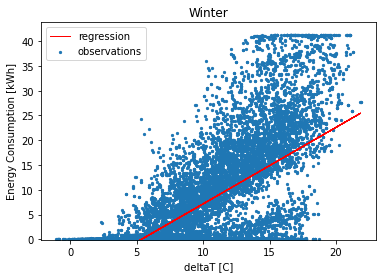

In [12]:
plotting(dataWint, 'Winter')

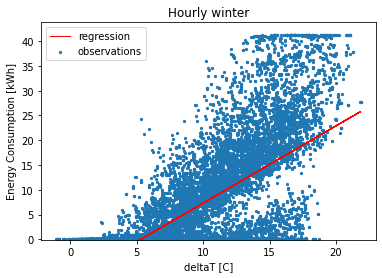

In [13]:
plotting(dataHW, 'Hourly winter')

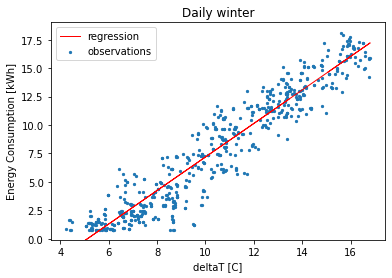

In [14]:
plotting(dataDW, 'Daily winter')

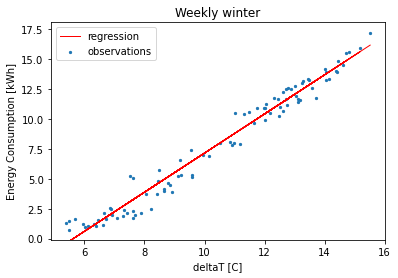

In [15]:
plotting(dataWW, 'Weekly winter')

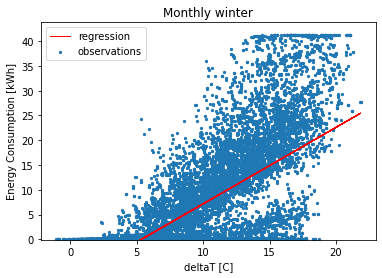

In [16]:
plotting(dataMW, 'Monthly winter')

### REGRESSION (Ordinary Least Square) - summer

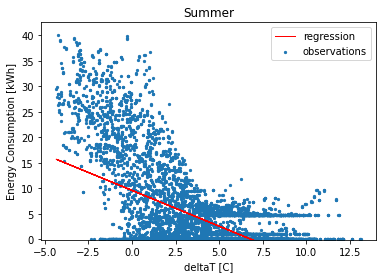

In [17]:
plotting(dataSum, 'Summer')

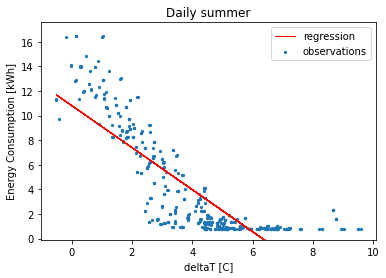

In [18]:
plotting(dataDS,'Daily summer')

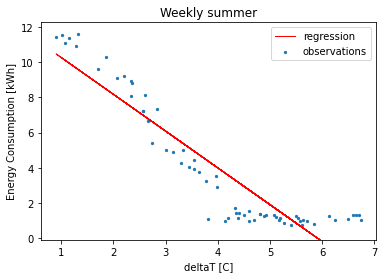

In [19]:
plotting(dataWS, 'Weekly summer')

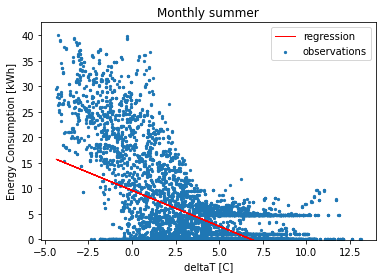

In [20]:
plotting(dataMS, 'Monthly summer')